In [1]:
using Clustering
using MultivariateStats
using StatsBase
using CSV
using DataFrames
using CairoMakie
using GaussianMixtures
using MLBase
using Hungarian
using LinearAlgebra

In [2]:
# Stop showing warnings
using Suppressor: @suppress_err

In [3]:
function ground_true(df_1, df_2)
    a = fill(1,nrow(df_1))
    b = fill(2,nrow(df_2))
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [4]:
# n is the number of cluters
# remember standardize trees for better performance
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;


function GMM_label(tree, n; method=:kmeans, kind=:diag)    
    data= tree';
    gmm=GMM(n,Array(data),method=method, kind=kind);
    prob_pos=gmmposterior(gmm,Array(data))[1]
    llpg = gmmposterior(gmm,Array(data))[2]
    llpg_result = map(argmax, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return Pair(llpg_result, prob_result)
end;

function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [5]:
# Kmeans
function kmeans_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 1:n
        if i == 1
            continue
        end
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            pred_kmeans = kmeans_label(tree, 2)
            m,x = accuracy(2, gt, pred_kmeans)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

kmeans_matrix (generic function with 1 method)

In [6]:
# GMM
function gmm_matrix(trees, path_prob, path_llpg)
    @suppress_err begin
        n = length(trees)
        result_prob = zeros(n, n)
        result_llpg = zeros(n, n)
        for i in 1:n
            if i == 1
                continue
            end
            for j in  1:(i - 1)
                gt = ground_true(trees[i],trees[j])
                tree = vcat(trees[i],trees[j])
                tree = standardize_tree(tree)
                pred_prob, pred_llpg = GMM_label(tree, 2, method = :split)
                m,x = accuracy(2, gt, pred_prob)
                result_prob[i,j] = x
                result_prob[j,i] = x

                m,x = accuracy(2, gt, pred_llpg)
                result_llpg[i,j] = x
                result_llpg[j,i] = x        
            end
        end 
    
        header = Vector(1:n)
        header = string.(header)
        CSV.write(path_prob, DataFrame(result_prob, :auto),header = header);
        CSV.write(path_llpg, DataFrame(result_llpg, :auto),header = header);
    end
end

gmm_matrix (generic function with 1 method)

In [182]:
mutable struct UnrootedTree
    nodeNumber::Int64
    nodeLengths::Vector{Float64}
    innerBranch::String
    innerLenght::Float64
end

function Base.show(io::IO, t::UnrootedTree)
    println(io, "Unrooted Tree\n$(t.nodeNumber) nodes\n1|234: $(t.nodeLengths[1])\n2|134: $(t.nodeLengths[2])\n3|124: $(t.nodeLengths[3])\n4|123: $(t.nodeLengths[4])\n$(t.innerBranch): $(t.innerLenght)")
end

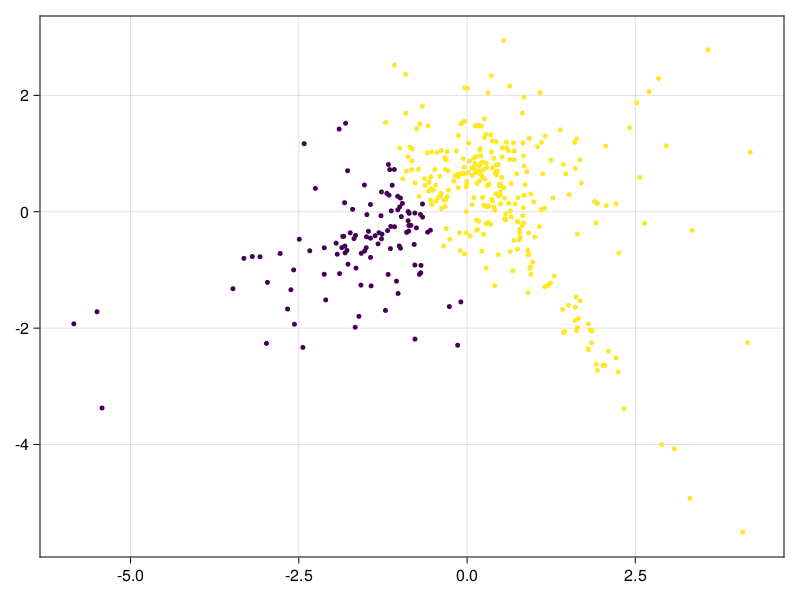

In [187]:
org_network = CSV.read("./data/network.csv", DataFrame)
network = standardize_tree(org_network)
label_NK = kmeans_label(network, 2)
plot_clusters(network, label_NK)

┌ Info: Initializing GMM, 2 Gaussians diag covariance 7 dimensions using 400 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79


K-means converged with 9 iterations (objv = 2351.71191575412)


┌ Info: K-means with 400 data points using 9 iterations
│ 25.0 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82

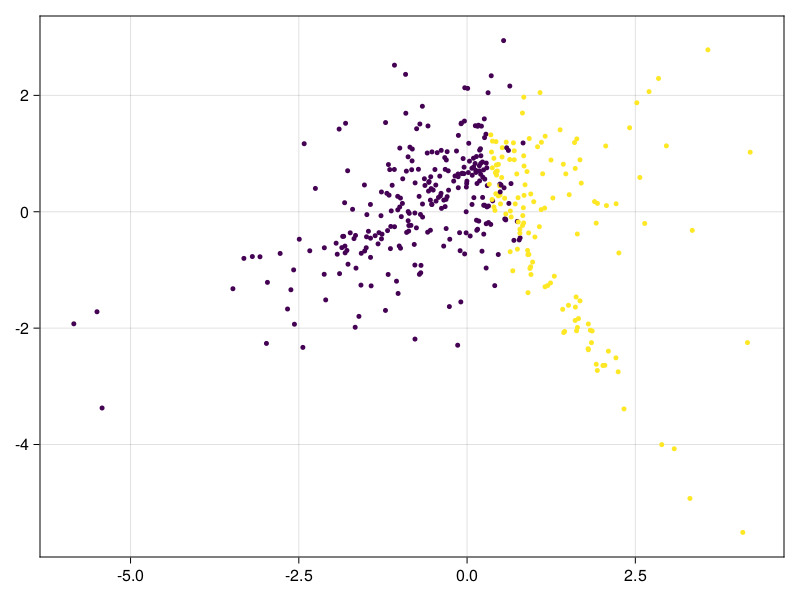

In [79]:
label_NG = GMM_label(network, 2)[2]
plot_clusters(network, label_NG)

In [10]:
tree_1 = CSV.read("./data/network_tree_1.csv", DataFrame)
tree_2 = CSV.read("./data/network_tree_2.csv", DataFrame)
gt = ground_true(tree_1, tree_2)
org_tree = vcat(tree_1,tree_2)
tree = standardize_tree(org_tree);

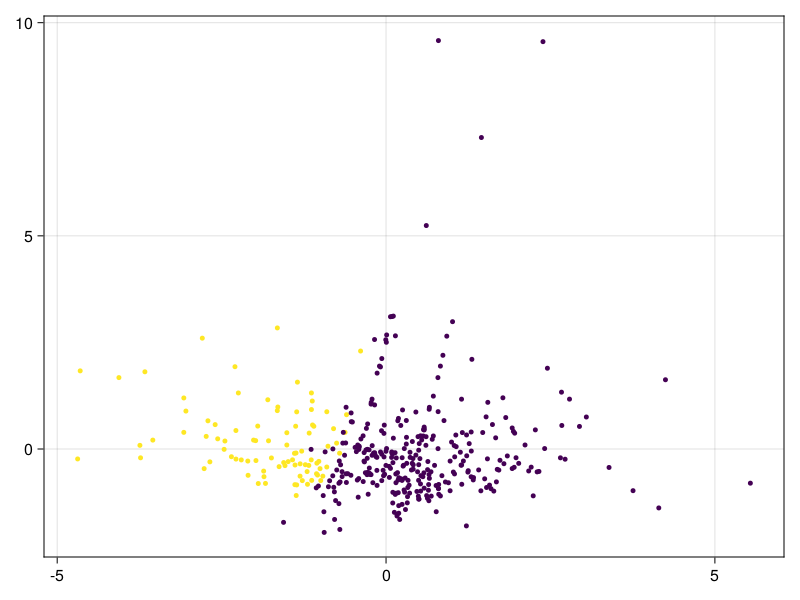

0.6725

In [32]:
label_K = kmeans_label(tree, 2)
matrix, x = accuracy(2, gt, label_K)
display(plot_clusters(tree, label_K))
print(x)

K-means converged with 13 iterations (objv = 2355.323521356151)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 7 dimensions using 400 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79
┌ Info: K-means with 400 data points using 13 iterations
│ 25.0 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [

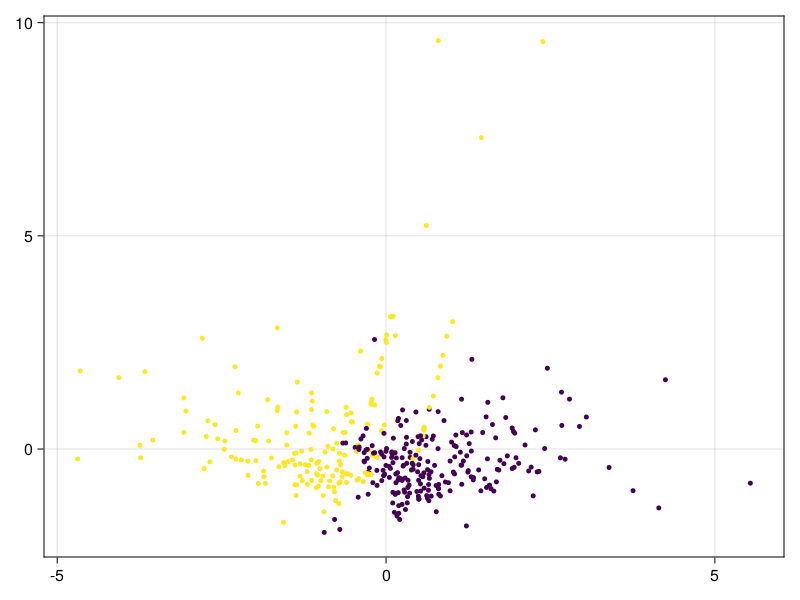

0.7625

In [52]:
label_GMM = GMM_label(tree, 2)[2]
display(plot_clusters(tree, label_GMM))
matrix, x = accuracy(2, gt, label_GMM)
print(x)

In [188]:
org_tree = Matrix(org_tree)
tree_K_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_K_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_K[i] == 1
        tree_K_1 += org_tree[i,:]
        n_1 += 1
    else
        tree_K_2 += org_tree[i,:]
        n_2 += 1
    end
end
tree_K_1 /= n_1
tree_K_2 /= n_2;

In [189]:
tree_G_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_G_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_GMM[i] == 1
        tree_G_1 += org_tree[i,:]
        n_1 += 1
    else
        tree_G_2 += org_tree[i,:]
        n_2 += 1
    end
end
tree_G_1 /= n_1
tree_G_2 /= n_2;

In [190]:
org_network = Matrix(org_network)
tree_NK_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_NK_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_NK[i] == 1
        tree_NK_1 += org_network[i,:]
        n_1 += 1
    else
        tree_NK_2 += org_network[i,:]
        n_2 += 1
    end
end
tree_NK_1 /= n_1
tree_NK_2 /= n_2;

In [191]:
tree_NG_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_NG_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_NG[i] == 1
        tree_NG_1 += org_network[i,:]
        n_1 += 1
    else
        tree_NG_2 += org_network[i,:]
        n_2 += 1
    end
end
tree_NG_1 /= n_1
tree_NG_2 /= n_2;

In [192]:
println("Network, Kmeans:")
println(tree_NK_1)
println(tree_NK_2)
println("Network, GMM:")
println(tree_NG_1)
println(tree_NG_2)
println("Tree, Kmeans:")
println(tree_K_1)
println(tree_K_2)
println("Tree, GMM:")
println(tree_G_1)
println(tree_G_2)

Network, Kmeans:
[1.7351533544168574, 1.4851533544168571, 2.2037754130641694, 1.9550318176074017, 2.1174985893208627, 0.0, 0.0]
[2.5033754557396355, 1.9190127602399487, 0.9048801582871815, 3.0591558179753813, 0.22861159320248742, 0.27911188873051934, 0.3528865488818513]
Network, GMM:
[1.9253261584119041, 1.5469382684171904, 1.4649049680075976, 2.9680851191479274, 1.1218947815593052, 0.004825471421837918, 0.014392068640885644]
[3.0074555889829497, 2.2912665961559413, 0.853742658721087, 2.363580648281069, 0.002818286946585962, 0.585631916243564, 0.7245091840945083]
Tree, Kmeans:
[2.0581458335272385, 1.9232591945908932, 1.5846697349982466, 3.23328894044171, 0.17706442007834247, 0.13185130863435543, 0.8423125161679988]
[1.4503654270059325, 1.5614078317140268, 2.8354006244124657, 2.2466081330257266, 1.9254215113244462, 0.001317145853703658, 0.0]
Tree, GMM:
[2.2106729357924007, 1.756155091618215, 1.5443088939567131, 3.2497802755189533, 0.05579934203333404, 0.002058070940694697, 1.15400525342

In [193]:
using Combinatorics

# n is the number of nodes
function buildValidTree(tree, n)
     # delete the two shortest lengths
    # the index of length should not be less than the number of nodes 
    count = 0
    for length in tree
        if length == 0
            count = count + 1
        end
    end
    
    if count != 2
        idx1 = findmin(tree)[2]
        idx2 = 1
        for i in n:length(tree)
            if i == idx1
                continue
            else
                if tree[i] <= tree[idx2]
                    idx2 = i
                end
            end
        end
        tree[idx1] = 0
        tree[idx2] = 0
    end
    return tree
end

function bipartToTree(tree, n)    
    lengths = tree[(n+1):length(tree)]
    idx1 = findmax(lengths)[2]
    
    comb = combinations(Vector(1:n),2)   # only for n=4
    idx2 = 0
    for c in comb
        idx2 = idx2 + 1
        if idx2 == idx1
            comb = c
        end
    end
    node = Vector(1:n)
    right = setdiff(node ,comb)
    
    innerBranch = ""
    
    for i in comb
        innerBranch = innerBranch * string(i)
    end  
    innerBranch = innerBranch * "|"  
    for i in right
        innerBranch = innerBranch * string(i)
    end
    
    unRootedTree = UnrootedTree(n, tree[1:n], innerBranch, findmax(lengths)[1])
end

bipartToTree (generic function with 1 method)

In [194]:
tree_NK_1 = buildValidTree(tree_NK_1, 4)
tree_NK_2 = buildValidTree(tree_NK_2, 4)
tree_NG_1 = buildValidTree(tree_NG_1, 4)
tree_NG_2 = buildValidTree(tree_NG_2, 4)
tree_K_1 = buildValidTree(tree_K_1, 4)
tree_K_2 = buildValidTree(tree_K_2, 4)
tree_G_1 = buildValidTree(tree_G_1, 4)
tree_G_2 = buildValidTree(tree_G_2, 4)

7-element Vector{Float64}:
 1.5453359584140176
 1.9563682123871755
 2.281068348144452
 2.7040512241263546
 1.2356248468825048
 0.0
 0.0

In [195]:
# draw points on network
network = CSV.read("./data/network.csv", DataFrame)
network = Matrix(network)'

sd_model = fit(ZScoreTransform, network, dims=2)
network = StatsBase.transform(sd_model, network)
replace!(network, NaN=>0)

PCA_model = fit(PCA, network, maxoutdim = 2)
PCA_network = predict(PCA_model,network)

2×400 Matrix{Float64}:
 0.491     0.487597   0.139863  0.558515  …   1.23977  -0.263108  2.06012
 0.287908  0.475049  -0.145507  0.232011     -1.22399  -1.62979   1.12994

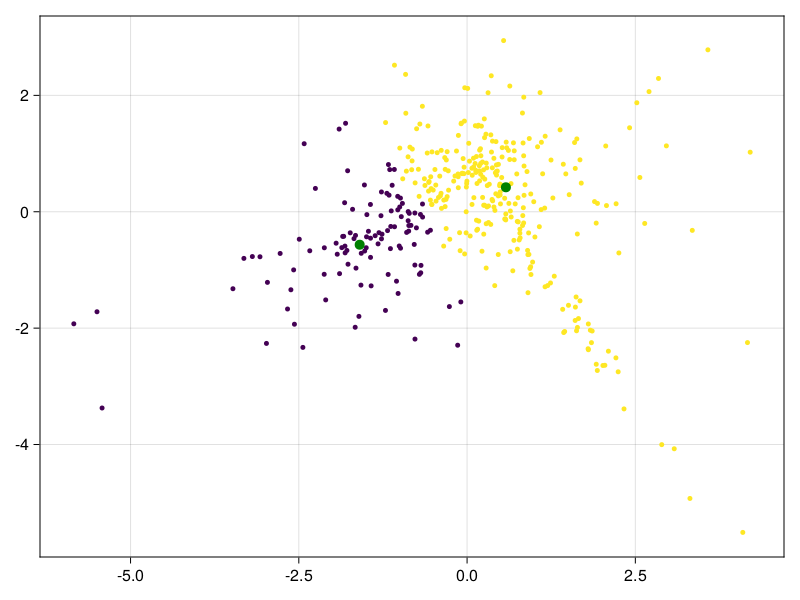

In [196]:
NK_1 = StatsBase.transform(sd_model, tree_NK_1)
NK_1 = predict(PCA_model,NK_1)
NK_2 = StatsBase.transform(sd_model, tree_NK_2)
NK_2 = predict(PCA_model,NK_2)

f = scatter(PCA_network[1,:], PCA_network[2,:], markersize = 5, color = label_NK)
scatter!(NK_1[1], NK_1[2], color = "green", label = "", markersize = 10)
scatter!(NK_2[1], NK_2[2], color = "green", label = "", markersize = 10)
f

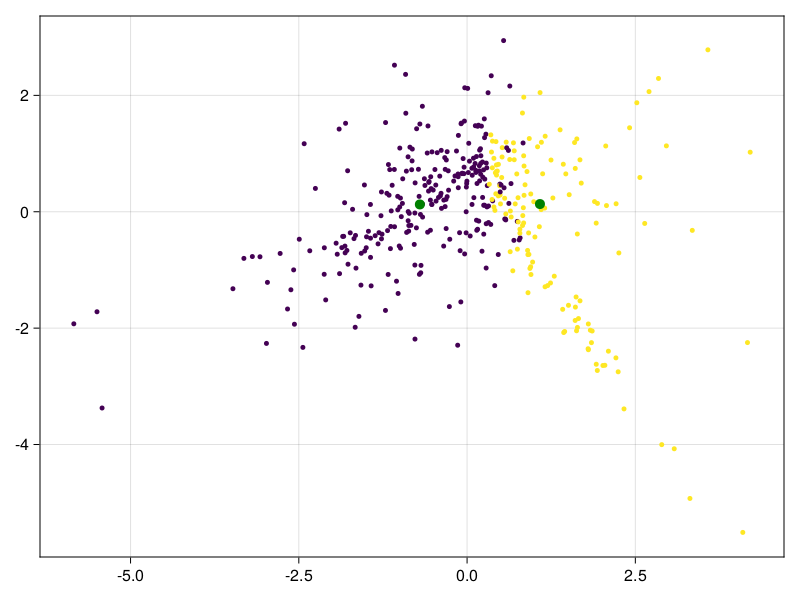

In [197]:
NG_1 = StatsBase.transform(sd_model, tree_NG_1)
NG_1 = predict(PCA_model,NG_1)
NG_2 = StatsBase.transform(sd_model, tree_NG_2)
NG_2 = predict(PCA_model,NG_2)

f = scatter(PCA_network[1,:], PCA_network[2,:], markersize = 5, color = label_NG)
scatter!(NG_1[1], NG_1[2], color = "green", label = "", markersize = 10)
scatter!(NG_2[1], NG_2[2], color = "green", label = "", markersize = 10)
f

In [198]:
# draw points on tree
tree_1 = CSV.read("./data/network_tree_1.csv", DataFrame)
tree_2 = CSV.read("./data/network_tree_2.csv", DataFrame)
tree = vcat(tree_1,tree_2)
tree = Matrix(tree)'

sd_model = fit(ZScoreTransform, tree, dims=2)
tree = StatsBase.transform(sd_model,tree)
replace!(tree, NaN=>0)

PCA_model = fit(PCA, tree, maxoutdim = 2)
PCA_tree = predict(PCA_model,tree)

2×400 Matrix{Float64}:
 -0.955242  -0.603006  -2.28167   2.3861   …   0.659169   0.155811  -0.52907
 -1.09257   -0.785263  -0.236378  9.55488     -0.688421  -0.209435   0.640663

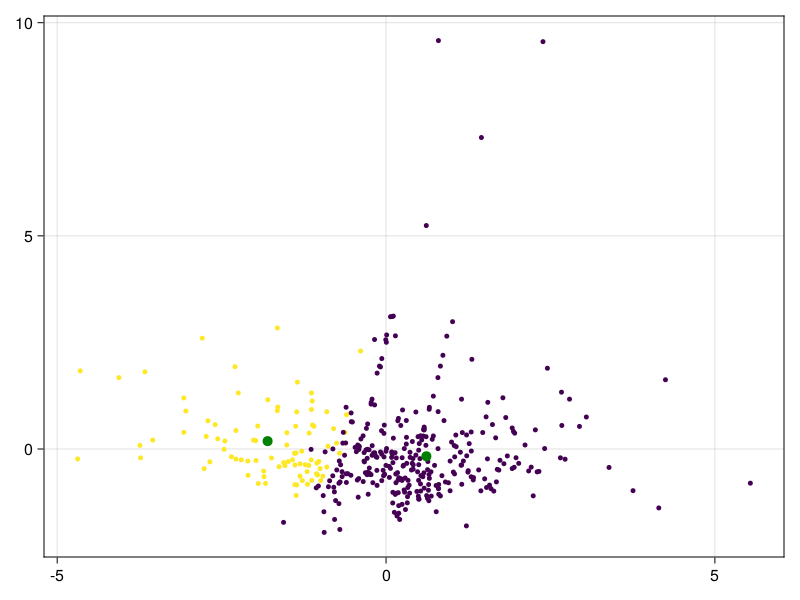

In [199]:
K_1 = StatsBase.transform(sd_model, tree_K_1)
K_1 = predict(PCA_model,K_1)
K_2 = StatsBase.transform(sd_model, tree_K_2)
K_2 = predict(PCA_model,K_2)

f = scatter(PCA_tree[1,:], PCA_tree[2,:], markersize = 5, color = label_K)
scatter!(K_1[1], K_1[2], color = "green", label = "", markersize = 10)
scatter!(K_2[1], K_2[2], color = "green", label = "", markersize = 10)
f

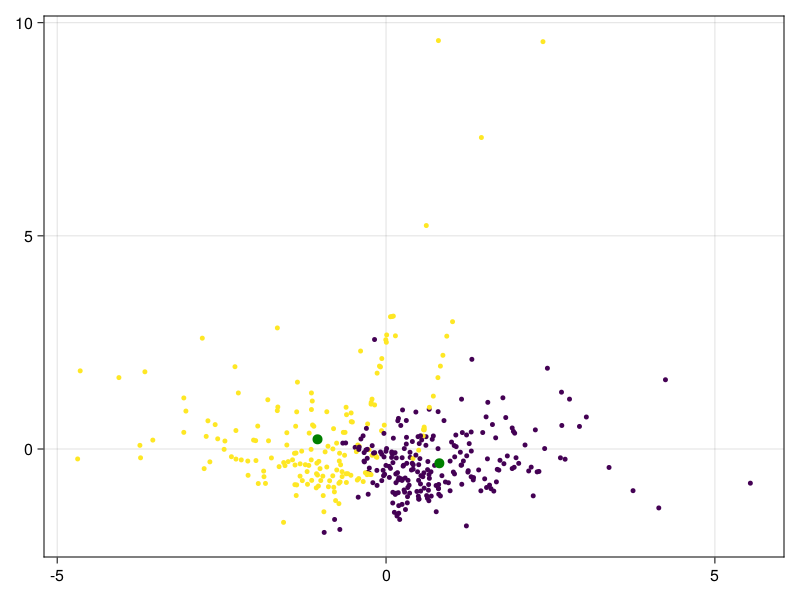

In [201]:
G_1 = StatsBase.transform(sd_model, tree_G_1)
G_1 = predict(PCA_model,G_1)
G_2 = StatsBase.transform(sd_model, tree_G_2)
G_2 = predict(PCA_model,G_2)

f = scatter(PCA_tree[1,:], PCA_tree[2,:], markersize = 5, color = label_GMM)
scatter!(G_1[1], G_1[2], color = "green", label = "", markersize = 10)
scatter!(G_2[1], G_2[2], color = "green", label = "", markersize = 10)
f

In [174]:
tree_NK_1 = bipartToTree(tree_NK_1, 4)
tree_NK_2 = bipartToTree(tree_NK_2, 4)
tree_NG_1 = bipartToTree(tree_NG_1, 4)
tree_NG_2 = bipartToTree(tree_NG_2, 4)
tree_K_1 = bipartToTree(tree_K_1, 4)
tree_K_2 = bipartToTree(tree_K_2, 4)
tree_G_1 = bipartToTree(tree_G_1, 4)
tree_G_2 = bipartToTree(tree_G_2, 4)

Unrooted Tree
4 nodes
1|234: 1.5453359584140176
2|134: 1.9563682123871755
3|124: 2.281068348144452
4|123: 2.7040512241263546
12|34: 1.2356248468825048


In [89]:
println("Network, Kmeans:")
println(tree_NK_1)
println(tree_NK_2)
println("Network, GMM:")
println(tree_NG_1)
println(tree_NG_2)
println("Tree, Kmeans:")
println(tree_K_1)
println(tree_K_2)
println("Tree, GMM:")
println(tree_G_1)
println(tree_G_2)

Network, Kmeans:
Unrooted Tree
4 nodes
1|234: 2.5033754557396355
2|134: 1.9190127602399487
3|124: 0.9048801582871815
4|123: 3.0591558179753813
14|23: 0.3528865488818513

Unrooted Tree
4 nodes
1|234: 1.7351533544168574
2|134: 1.4851533544168571
3|124: 2.2037754130641694
4|123: 1.9550318176074017
12|34: 2.1174985893208627

Network, GMM:
Unrooted Tree
4 nodes
1|234: 1.9253261584119041
2|134: 1.5469382684171904
3|124: 1.4649049680075976
4|123: 2.9680851191479274
12|34: 1.1218947815593052

Unrooted Tree
4 nodes
1|234: 3.0074555889829497
2|134: 2.2912665961559413
3|124: 0.853742658721087
4|123: 2.363580648281069
14|23: 0.7245091840945083

Tree, Kmeans:
Unrooted Tree
4 nodes
1|234: 2.0581458335272385
2|134: 1.9232591945908932
3|124: 1.5846697349982466
4|123: 3.23328894044171
14|23: 0.8423125161679988

Unrooted Tree
4 nodes
1|234: 1.4503654270059325
2|134: 1.5614078317140268
3|124: 2.8354006244124657
4|123: 2.2466081330257266
12|34: 1.9254215113244462

Tree, GMM:
Unrooted Tree
4 nodes
1|234: 2